In [1]:
import numpy as np
import pandas as pd
import datetime
from dateutil.rrule import rrule, MONTHLY
import matplotlib.pyplot as plt

AZ_reviews = pd.read_csv('AZ_review.csv')

In [2]:
print(AZ_reviews.columns)
AZ_reviews.describe()

Index(['Unnamed: 0', 'business_id', 'name', 'cool', 'date', 'funny',
       'review_id', 'stars', 'text', 'useful', 'user_id', 'categories',
       'attributes'],
      dtype='object')


,Unnamed: 0,cool,funny,stars,useful
count,1.877589e+06,1.877589e+06,1.877589e+06,1.877589e+06,1.877589e+06
mean,2.997879e+06,5.401640e-01,4.793834e-01,3.785140e+00,1.400640e+00
std,1.702537e+06,2.337093e+00,3.132605e+00,1.502391e+00,4.451211e+00
min,3.200000e+01,-1.000000e+00,0.000000e+00,1.000000e+00,-1.000000e+00
25%,1.492337e+06,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00
50%,3.059081e+06,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00
75%,4.456132e+06,0.000000e+00,0.000000e+00,5.000000e+00,2.000000e+00
max,5.995863e+06,5.050000e+02,9.910000e+02,5.000000e+00,1.234000e+03


In [3]:
AZ_reviews['business_id'].describe()

count                    1877589
unique                     56495
top       JmI9nslLD7KZqRr__Bg6NQ
freq                        2390
Name: business_id, dtype: object

In [4]:
top_biz = "JmI9nslLD7KZqRr__Bg6NQ"
top_reviews = AZ_reviews[AZ_reviews['business_id'] == "JmI9nslLD7KZqRr__Bg6NQ"]
top_reviews_sorted = top_reviews.sort(columns='date')
top_reviews_sorted.head()['date']

/share/apps/python3/3.5.3/intel/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


345010    2006-06-25
345156    2006-08-07
344760    2006-08-13
344537    2006-08-30
344707    2006-09-03
Name: date, dtype: object

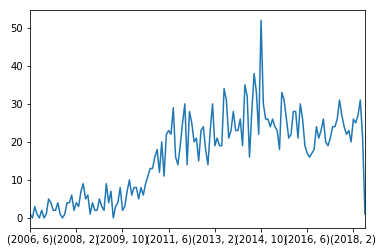

In [5]:
top_reviews_date = top_reviews.assign(datetime = pd.to_datetime(top_reviews_sorted['date'])).drop(labels=['date'], axis = 'columns')


top_reviews_reindexed = top_reviews_date.set_index('datetime').sort_index()
top_reviews_reindexed.index = top_reviews_reindexed.index.map(lambda t: t.replace(day=1))

min_date = pd.Timestamp(top_reviews_reindexed.index.min())
max_date = pd.Timestamp(top_reviews_reindexed.index.max())
dates = [dt for dt in rrule(MONTHLY, dtstart=min_date, until=max_date)]
date_frame = pd.DataFrame(dates, columns = ['datetime']).set_index('datetime')

all_dates = date_frame.join(top_reviews_reindexed)


groupbymonth = all_dates.groupby([all_dates.index.year, all_dates.index.month])

groupbymonth['business_id'].count().plot()
plt.show()



In [33]:
def hwr(x):
    return (x+np.abs(x))/2

def plot_by_month(df, business_id = None, label = None, plottype = 'count', compare_mean = False):
    reviews_sorted = df.sort(columns='date')
    reviews_datetime = reviews_sorted.assign(datetime = pd.to_datetime(reviews_sorted['date'])).drop(labels=['date'], axis = 'columns')
    reviews_reindexed = reviews_datetime.set_index('datetime').sort_index()
    reviews_reindexed.index = reviews_reindexed.index.map(lambda t: t.replace(day=1))
    
    if business_id != None:
        reviews = reviews_reindexed[reviews_reindexed['business_id'] == business_id]
        title = reviews.loc[reviews.index[0]]['name']
    else:
        reviews = reviews_reindexed
        title = 'All Businesses'
    
    if label == None:
        label = 'business_id'
        title += ' - review ' + plottype
    else: 
        title += ' - ' + label + ' ' + plottype
    
    min_date = pd.Timestamp(reviews.index.min())
    max_date = pd.Timestamp(reviews.index.max())
    dates = [dt for dt in rrule(MONTHLY, dtstart=min_date, until=max_date)]
    date_frame = pd.DataFrame(dates, columns = ['datetime']).set_index('datetime')
    
    all_dates = date_frame.join(reviews)
    group_by_month = all_dates.groupby([all_dates.index.year, all_dates.index.month])
    
    if compare_mean == True:
        all_reviews = reviews_reindexed
        all_reviews_dates = date_frame.join(all_reviews)
        all_group_by_month  = all_reviews_dates.groupby([all_reviews_dates.index.year, all_reviews_dates.index.month])
        all_group_by_unique = all_group_by_month['business_id'].unique().apply(len)
        avg_group_by_month = all_group_by_month/all_group_by_unique

    if plottype == 'cumsum':
        np.cumsum(group_by_month[label].count()).plot(label = plottype)
    elif plottype == 'diff':
        diff = (np.diff(group_by_month[label].count()))
        plt.plot(date_frame.index[:-1], diff, label = plottype)
    elif plottype == 'pos_diff':
        diff = hwr(np.diff(group_by_month[label].count()))
        plt.plot(date_frame.index[:-1], diff, label = plottype)
    elif plottype == 'count':
        group_by_month[label].count().plot(label = plottype)    
        
    if compare_mean == True:
        if plottype == 'cumsum':
            np.cumsum(avg_group_by_month[label].count()).plot(label = plottype)
        elif plottype == 'diff':
            diff = (np.diff(avg_group_by_month[label].count()))
            plt.plot(date_frame.index[:-1], diff, label = plottype)
        elif plottype == 'pos_diff':
            diff = hwr(np.diff(avg_group_by_month[label].count()))
            plt.plot(date_frame.index[:-1], diff, label = plottype)
        elif plottype == 'count':
            avg_group_by_month[label].count().plot(label = plottype) 

        
        
    plt.title(title)
    plt.legend()
    plt.show()
    return group_by_month
    

In [34]:
business_groups = AZ_reviews.groupby('business_id')
sorted_groups = business_groups.size().sort_values(ascending=False)
for business_id, size in (sorted_groups.items()):
    if size>1000:
        plot_by_month(AZ_reviews, business_id = business_id, plottype = 'pos_diff', compare_mean=True)

/share/apps/python3/3.5.3/intel/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


ValueError: operands could not be broadcast together with shapes (146,2) (146,) 

/share/apps/python3/3.5.3/intel/lib/python3.5/site-packages/ipykernel/__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


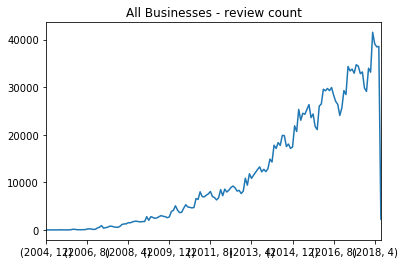

In [8]:
all_reviews = plot_by_month(AZ_reviews)


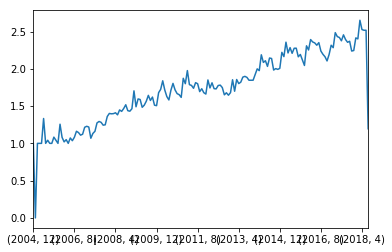

In [24]:
all_reviews_count = all_reviews['business_id'].count()
all_reviews_unique = all_reviews['business_id'].unique().apply(len)
(all_reviews_count/all_reviews_unique).plot()
plt.show()

In [14]:
cats = AZ_reviews['categories'].str.contains('Food')
print(cats)

0          False
1          False
2          False
3          False
4          False
5          False
6          False
7          False
8           True
9           True
10          True
11          True
12          True
13          True
14          True
15          True
16          True
17          True
18          True
19          True
20          True
21          True
22          True
23          True
24          True
25          True
26          True
27          True
28          True
29          True
           ...  
1877559    False
1877560    False
1877561    False
1877562    False
1877563    False
1877564    False
1877565    False
1877566    False
1877567    False
1877568    False
1877569    False
1877570    False
1877571    False
1877572    False
1877573    False
1877574    False
1877575    False
1877576    False
1877577    False
1877578    False
1877579    False
1877580    False
1877581    False
1877582    False
1877583    False
1877584    False
1877585    False
1877586    Fal